import h5py, os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.models as Model
from tensorflow.keras import layers
from keras.layers import Input, Reshape, Conv1D, Flatten, Dense, LayerNormalization, Dropout, GlobalAveragePooling1D, MultiHeadAttention
from keras.models import load_model, Sequential
from tensorflow.keras.optimizers import SGD, Adagrad, Adam

In [2]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(sample_num), size=sample_num)
# idx = np.random.choice(range(0,sample_num), size=sample_num//20)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    filename = 'ExtractDataset/part' + str(i) + '.h5'
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X-size：', X.shape)
print('Y-size：', Y.shape)
print('Z-size：', Z.shape)

X-size： (748800, 1024, 2)
Y-size： (748800, 24)
Z-size： (748800, 1)


In [3]:
n_examples = X.shape[0]
n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
Z_train = Z[train_idx]
Z_test = Z[test_idx]
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("Z_train:", Z_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("Z_test:", Z_test.shape)

X_train: (673920, 1024, 2)
Y_train: (673920, 24)
Z_train: (673920, 1)
X_test: (74880, 1024, 2)
Y_test: (74880, 24)
Z_test: (74880, 1)


In [ ]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

In [4]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    def get_config(self):
        cfg = super().get_config()
        return cfg    
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [5]:
def proposed_model(X_train,classes):

    embed_dim = 1024
    num_heads = 16
    ff_dim = 256

    in_shp = X_train.shape[1:]  
    X_input = Input(in_shp)
    
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    
    X = Reshape([2,1024], input_shape=in_shp)(X_input)
    x = transformer_block(X)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation="selu")(x)
    x = Dropout(0.2)(x)
    x = Dense(len(classes), activation="softmax")(x)
    return tf.keras.models.Model(inputs=X_input, outputs=x)
    
model = proposed_model(X_train, classes) 

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 2)]         0         
                                                                 
 reshape (Reshape)           (None, 2, 1024)           0         
                                                                 
 transformer_block (Transfor  (None, 2, 1024)          67688704  
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 1024)             0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              104960

In [6]:
filepath = 'TransformerBlock_model.keras'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=1,
    shuffle=True,
    validation_split = 0.1,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', min_delta=0.0001)
    ])

Epoch 1/100
592/593 [============================>.] - ETA: 0s - loss: 2.7953 - accuracy: 0.1463
Epoch 1: val_loss improved from inf to 2.41216, saving model to TransformerBlock_model.keras
593/593 [==============================] - 342s 410ms/step - loss: 2.7952 - accuracy: 0.1464 - val_loss: 2.4122 - val_accuracy: 0.1986
Epoch 2/100
592/593 [============================>.] - ETA: 0s - loss: 2.4912 - accuracy: 0.1918
Epoch 2: val_loss improved from 2.41216 to 2.35657, saving model to TransformerBlock_model.keras
593/593 [==============================] - 109s 183ms/step - loss: 2.4912 - accuracy: 0.1918 - val_loss: 2.3566 - val_accuracy: 0.2133
Epoch 3/100
592/593 [============================>.] - ETA: 0s - loss: 2.3993 - accuracy: 0.2088
Epoch 3: val_loss improved from 2.35657 to 2.32656, saving model to TransformerBlock_model.keras
593/593 [==============================] - 60s 101ms/step - loss: 2.3993 - accuracy: 0.2088 - val_loss: 2.3266 - val_accuracy: 0.2242
Epoch 4/100
592/59

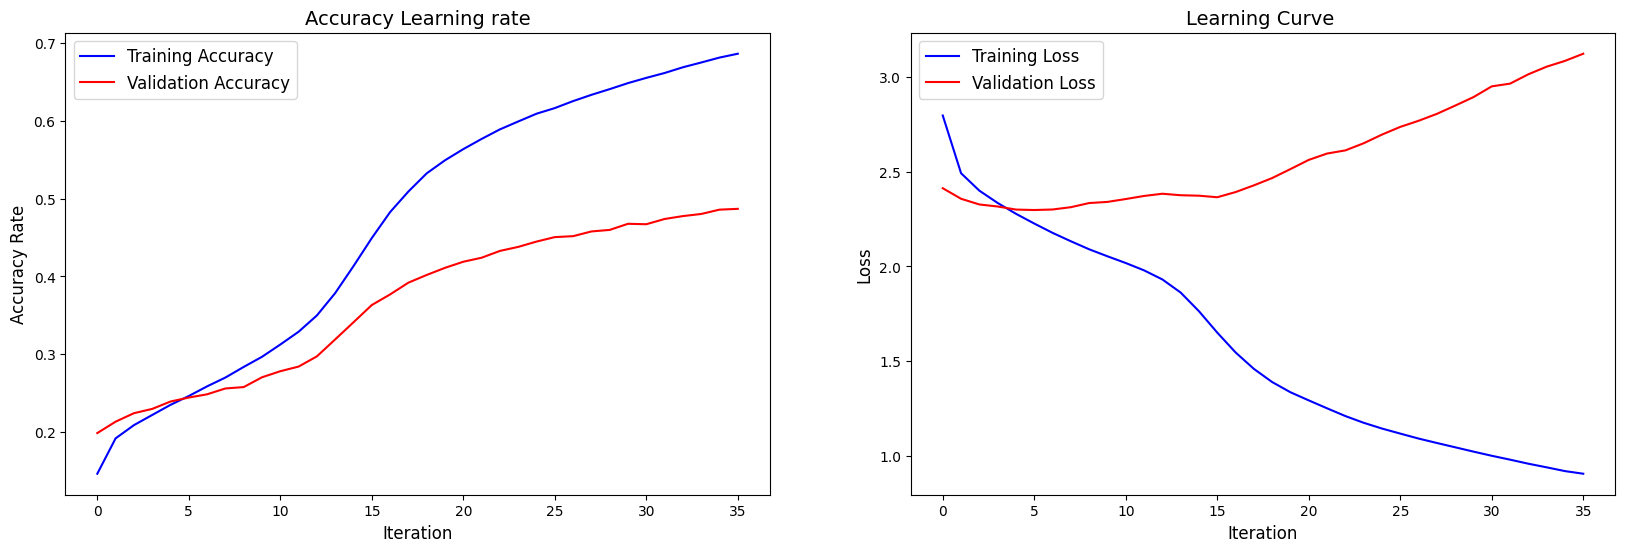

In [7]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Accuracy Learning rate',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

plt.show()

In [8]:
cnn_model = load_model('cnn_model.keras')
resnet_model = load_model('resnet_model.keras')

74/74 [==============================] - 5s 61ms/step


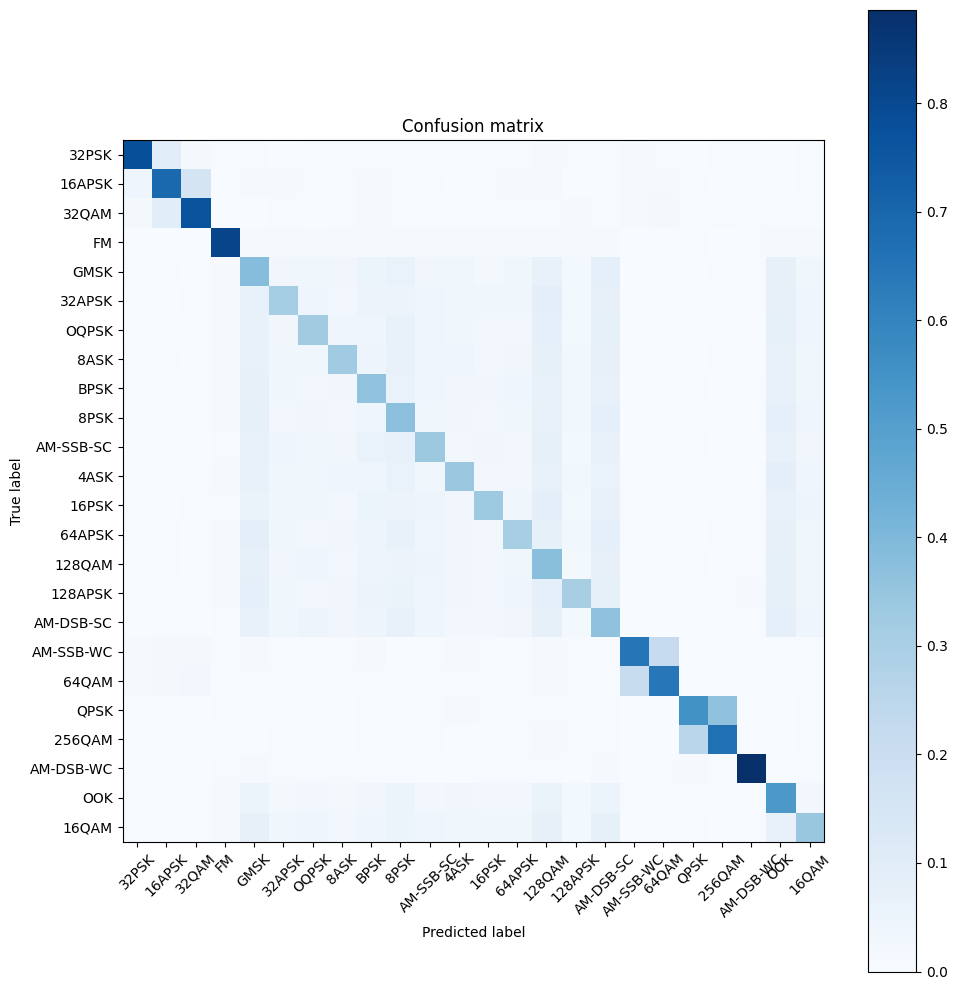

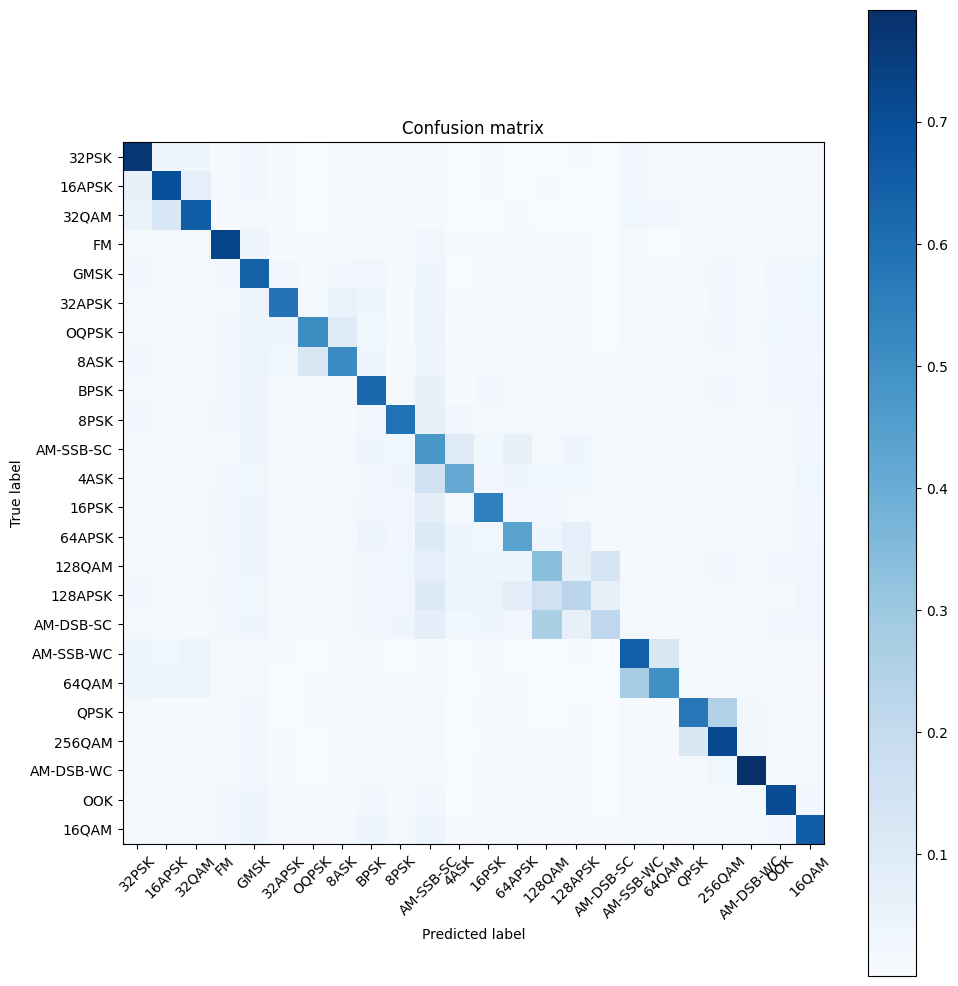

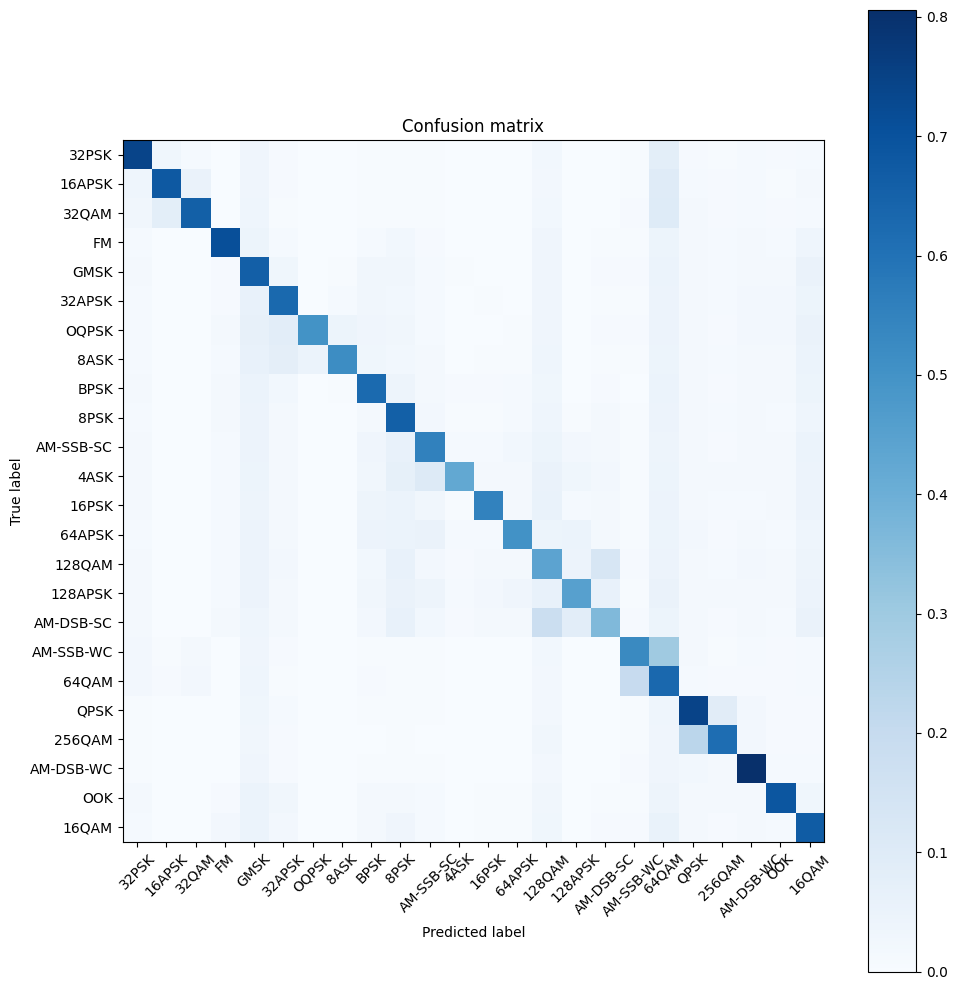

In [9]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_transformer = model.predict(X_test, batch_size=batch_size)
test_Y_cnn = cnn_model.predict(X_test, batch_size=batch_size)
test_Y_resnet = resnet_model.predict(X_test, batch_size=batch_size)
conf_transformer = np.zeros([len(classes),len(classes)])
confnorm_transformer = np.zeros([len(classes),len(classes)])
conf_cnn = np.zeros([len(classes),len(classes)])
confnorm_cnn = np.zeros([len(classes),len(classes)])
conf_resnet = np.zeros([len(classes),len(classes)])
confnorm_resnet = np.zeros([len(classes),len(classes)])
for i in range(0, X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_transformer[i,:]))
    conf_transformer[j,k] = conf_transformer[j,k] + 1
for i in range(0,len(classes)):
    confnorm_transformer[i,:] = conf_transformer[i,:] / np.sum(conf_transformer[i,:])
for i in range(0, X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_cnn[i,:]))
    conf_cnn[j,k] = conf_cnn[j,k] + 1
for i in range(0,len(classes)):
    confnorm_cnn[i,:] = conf_cnn[i,:] / np.sum(conf_cnn[i,:])
for i in range(0, X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_resnet[i,:]))
    conf_resnet[j,k] = conf_resnet[j,k] + 1
for i in range(0,len(classes)):
    confnorm_resnet[i,:] = conf_resnet[i,:] / np.sum(conf_resnet[i,:])
plot_confusion_matrix(confnorm_transformer, labels=classes)
plot_confusion_matrix(confnorm_cnn, labels=classes)
plot_confusion_matrix(confnorm_resnet, labels=classes)

93/93 [==============================] - 1s 5ms/step
Overall Accuracy -20:  0.5829945799457995
93/93 [==============================] - 1s 5ms/step
Overall Accuracy -18:  0.5688602442333786
93/93 [==============================] - 1s 6ms/step
Overall Accuracy -16:  0.5886906765398856
94/94 [==============================] - 0s 5ms/step
Overall Accuracy -14:  0.5938440950150552
91/91 [==============================] - 0s 5ms/step
Overall Accuracy -12:  0.5818935729094679
89/89 [==============================] - 1s 5ms/step
Overall Accuracy -10:  0.570773032121426
88/88 [==============================] - 0s 5ms/step
Overall Accuracy -8:  0.6268763402430307
90/90 [==============================] - 1s 5ms/step
Overall Accuracy -6:  0.5914166085136078
87/87 [==============================] - 1s 6ms/step
Overall Accuracy -4:  0.5944283646888567
92/92 [==============================] - 1s 6ms/step
Overall Accuracy -2:  0.6176772867420349
86/86 [==============================] - 0s 5ms/step
Ov

C:\Users\SomeUnknown\AppData\Local\Temp\ipykernel_25236\2896286211.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


93/93 [==============================] - 0s 4ms/step
Overall Accuracy 2:  0.49848024316109424
87/87 [==============================] - 0s 5ms/step
Overall Accuracy 4:  0.4366654637315049
89/89 [==============================] - 0s 5ms/step
Overall Accuracy 6:  0.4204024002823862
85/85 [==============================] - 0s 4ms/step
Overall Accuracy 8:  0.4133086876155268
90/90 [==============================] - 1s 6ms/step
Overall Accuracy 10:  0.38616614529023285
89/89 [==============================] - 0s 4ms/step
Overall Accuracy 12:  0.3988744284206824
90/90 [==============================] - 0s 5ms/step
Overall Accuracy 14:  0.4005582693649686
92/92 [==============================] - 0s 5ms/step
Overall Accuracy 16:  0.39197530864197533
87/87 [==============================] - 0s 5ms/step
Overall Accuracy 18:  0.41334300217548947
92/92 [==============================] - 0s 5ms/step
Overall Accuracy 20:  0.4151907356948229
90/90 [==============================] - 0s 5ms/step
Overall

<Figure size 640x480 with 0 Axes>

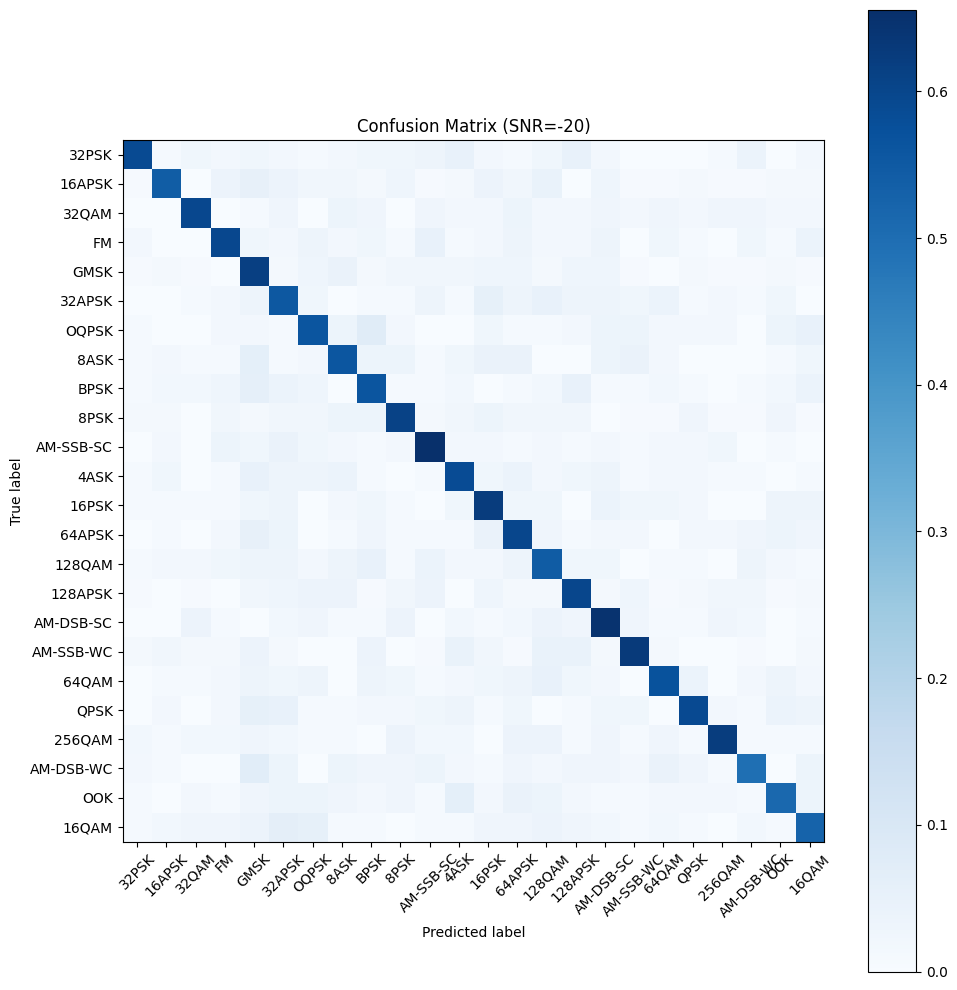

<Figure size 640x480 with 0 Axes>

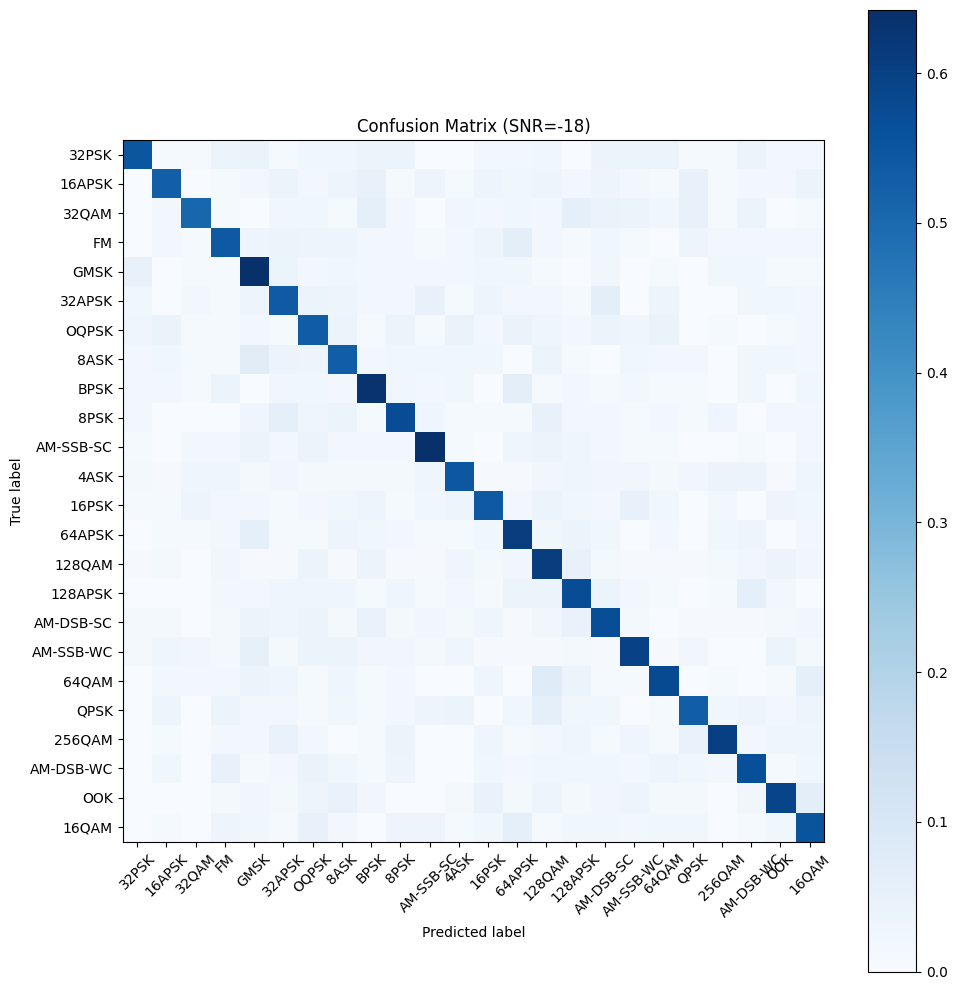

<Figure size 640x480 with 0 Axes>

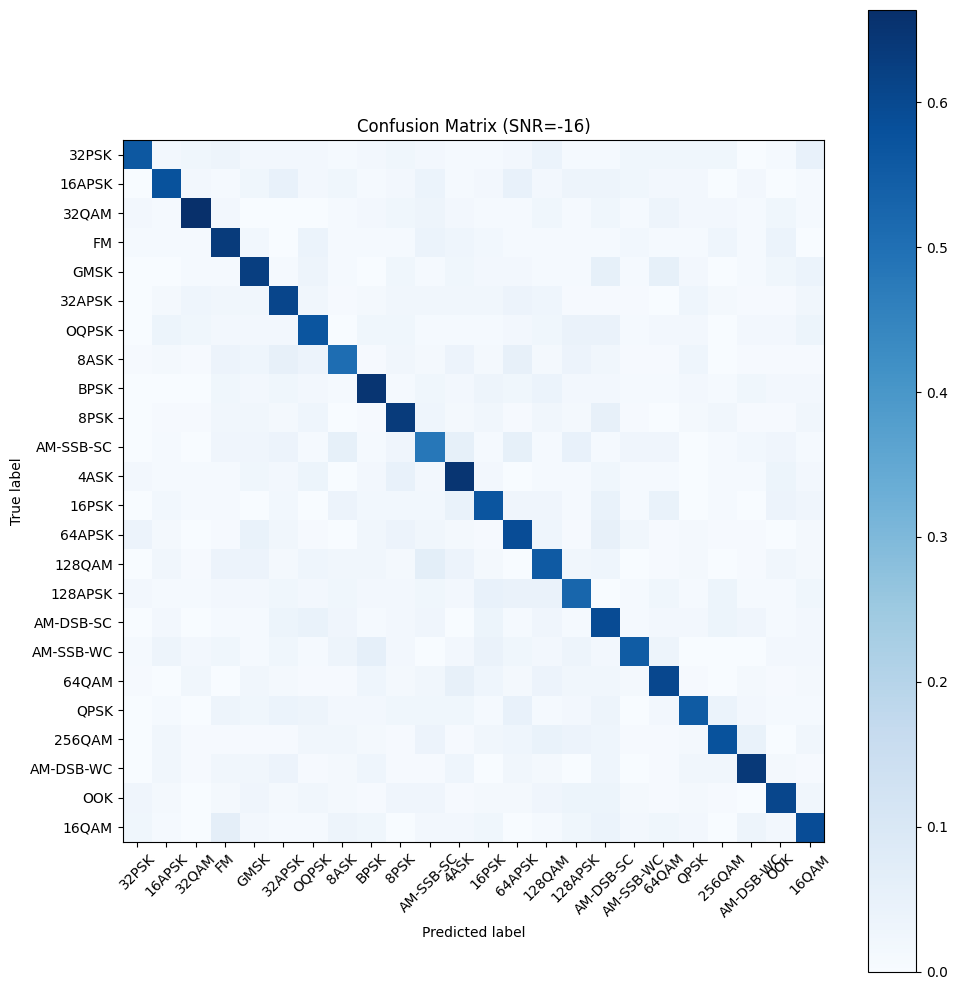

<Figure size 640x480 with 0 Axes>

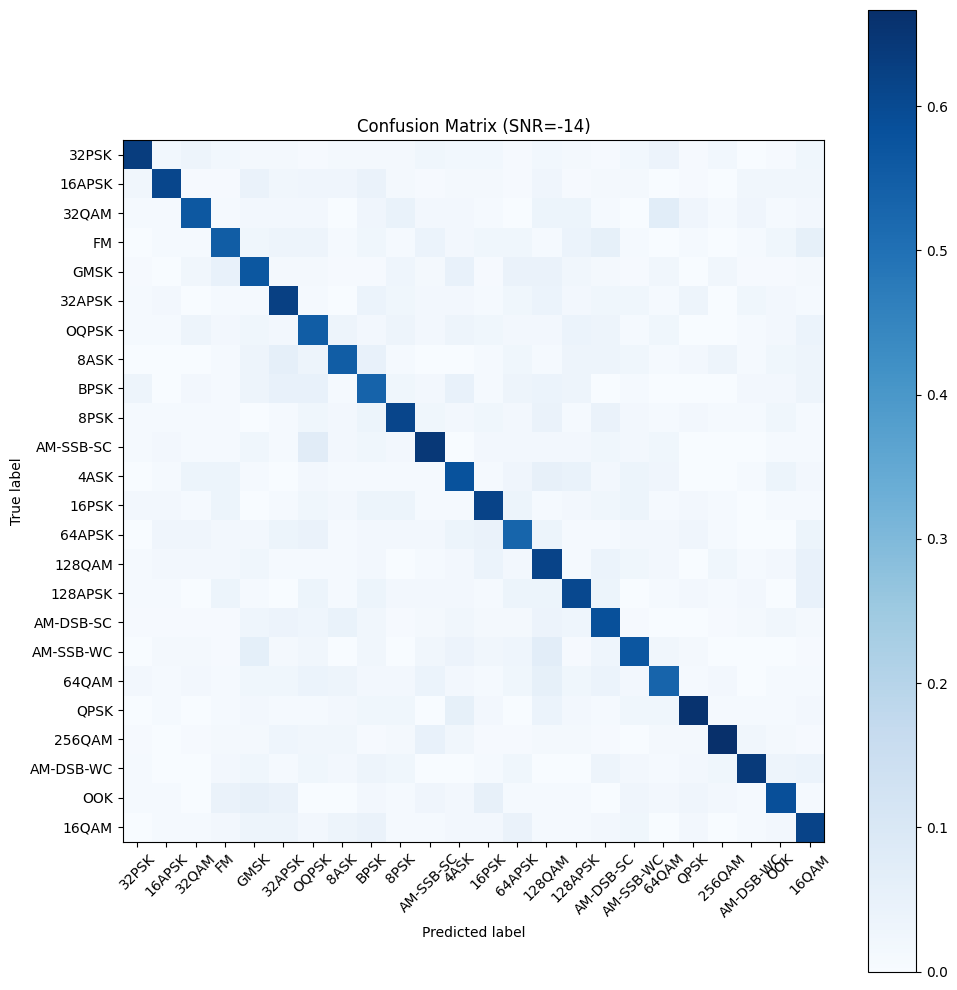

<Figure size 640x480 with 0 Axes>

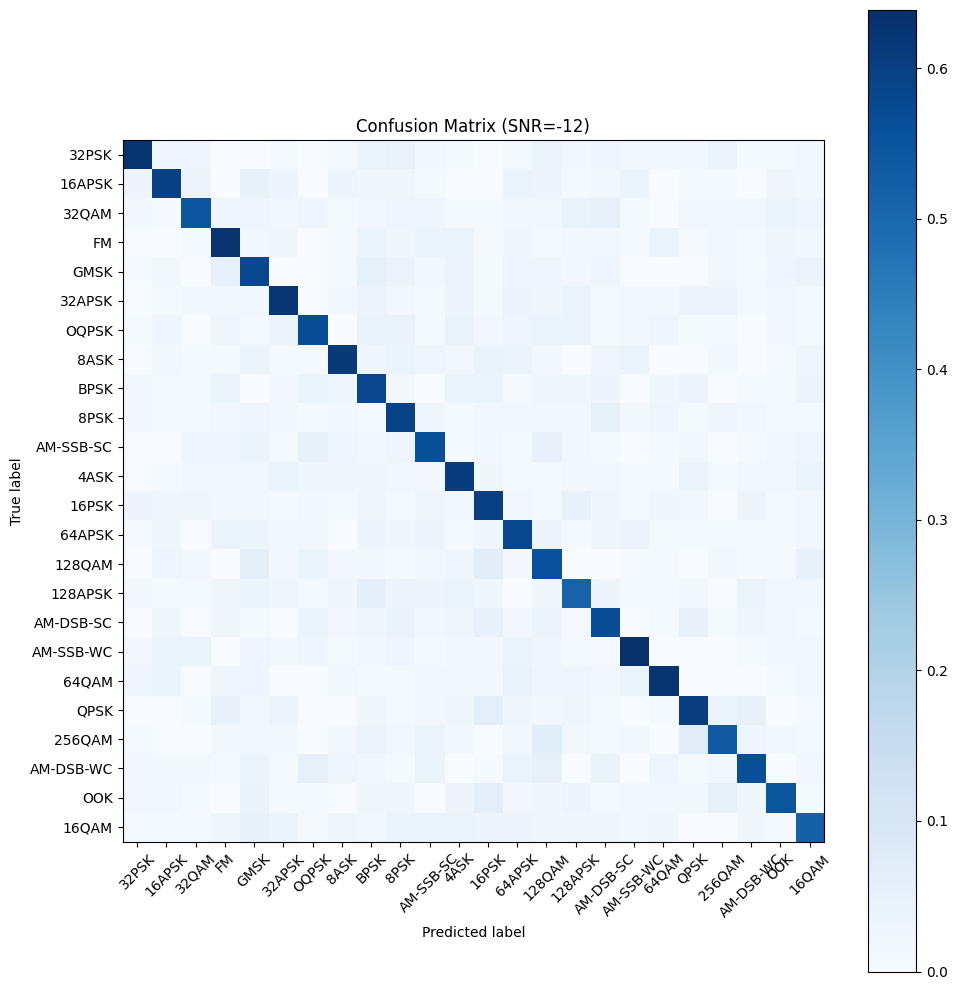

<Figure size 640x480 with 0 Axes>

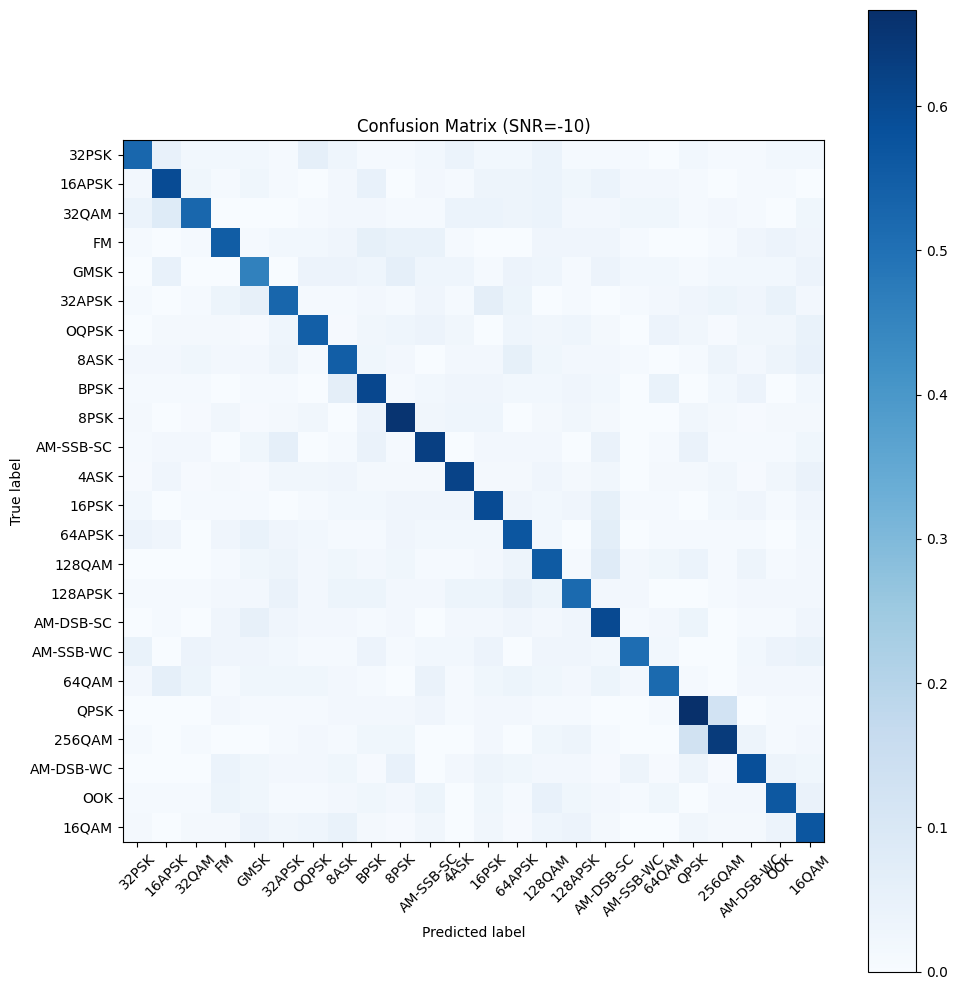

<Figure size 640x480 with 0 Axes>

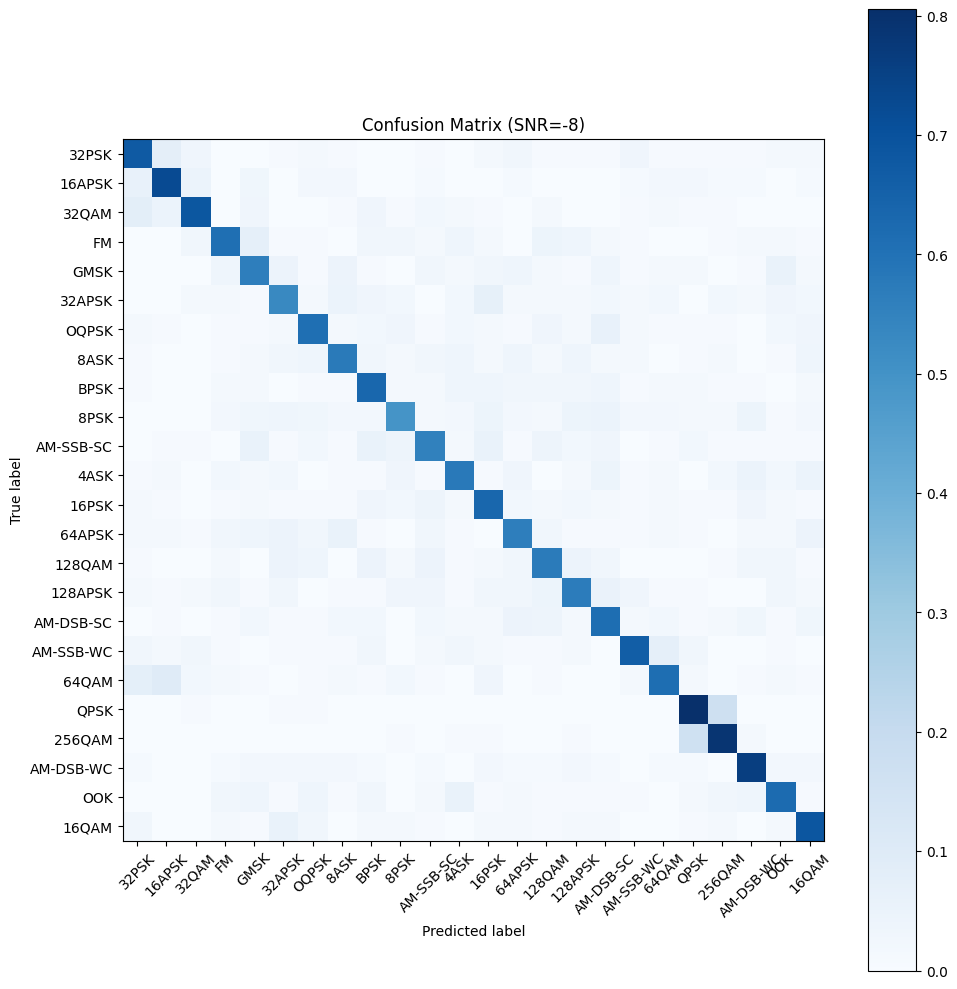

<Figure size 640x480 with 0 Axes>

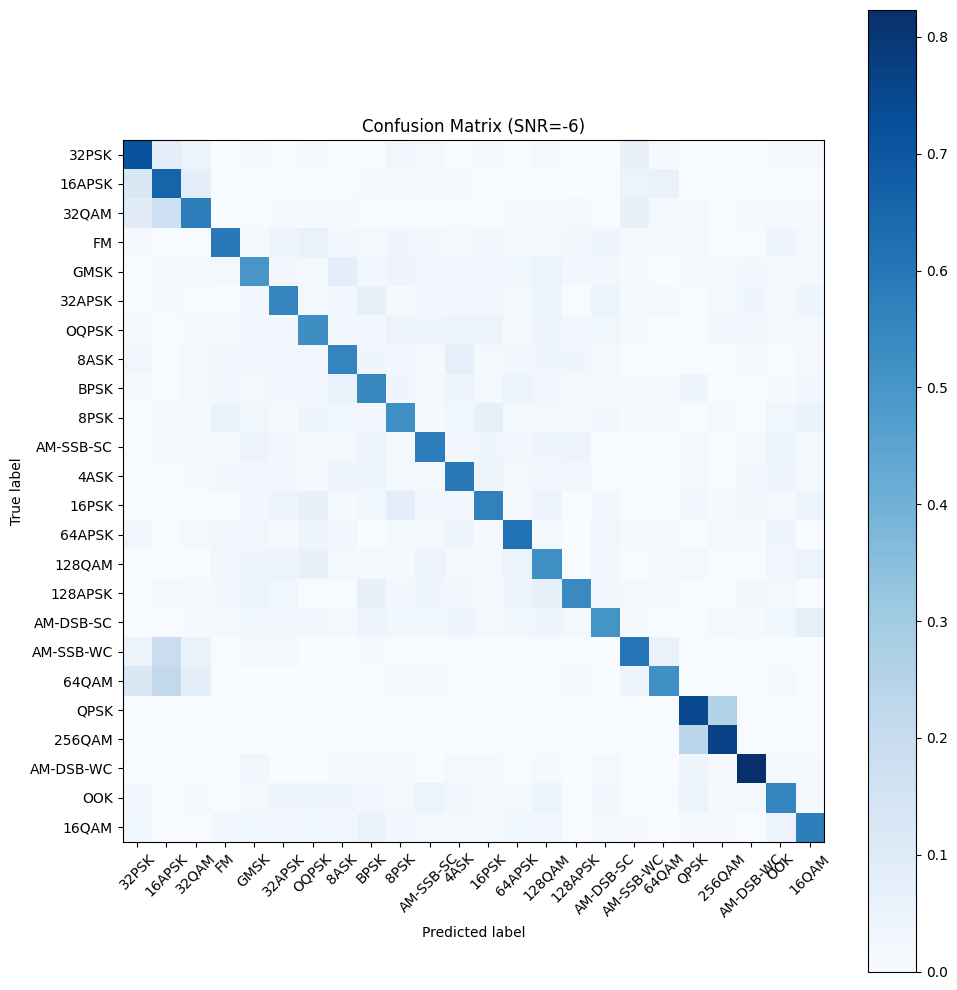

<Figure size 640x480 with 0 Axes>

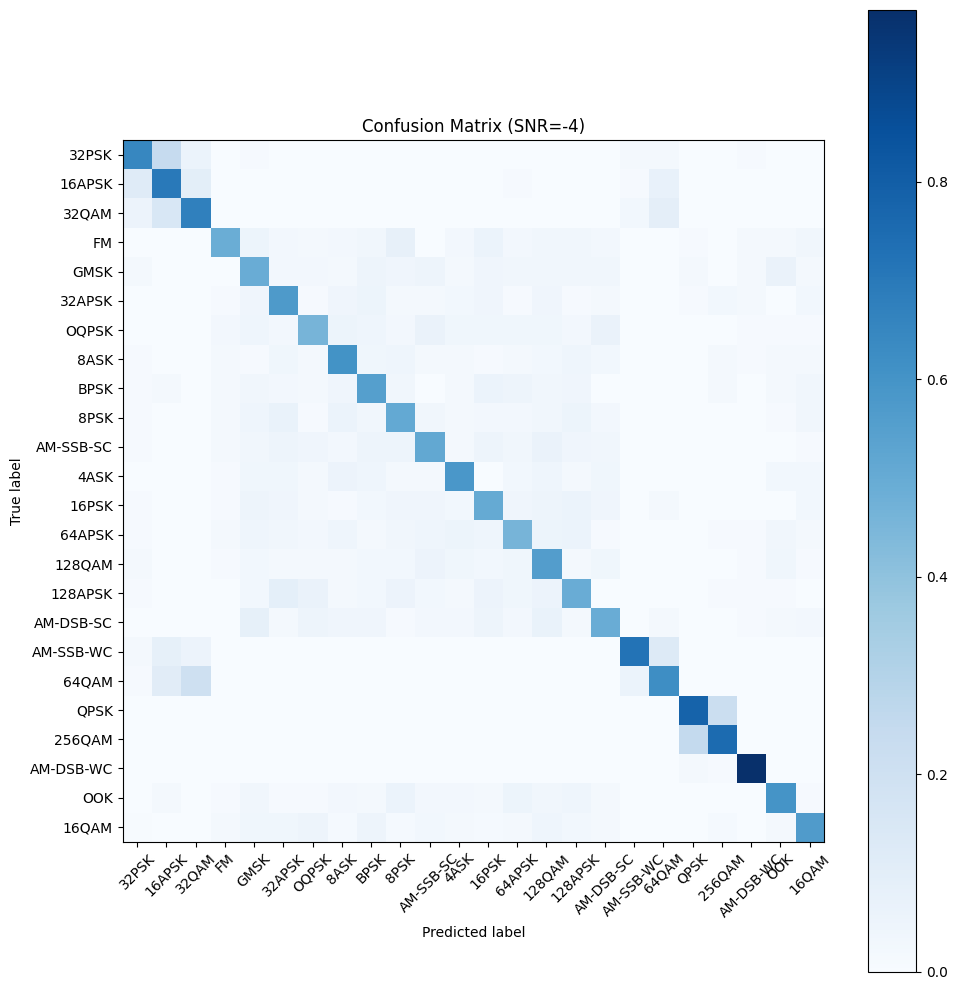

<Figure size 640x480 with 0 Axes>

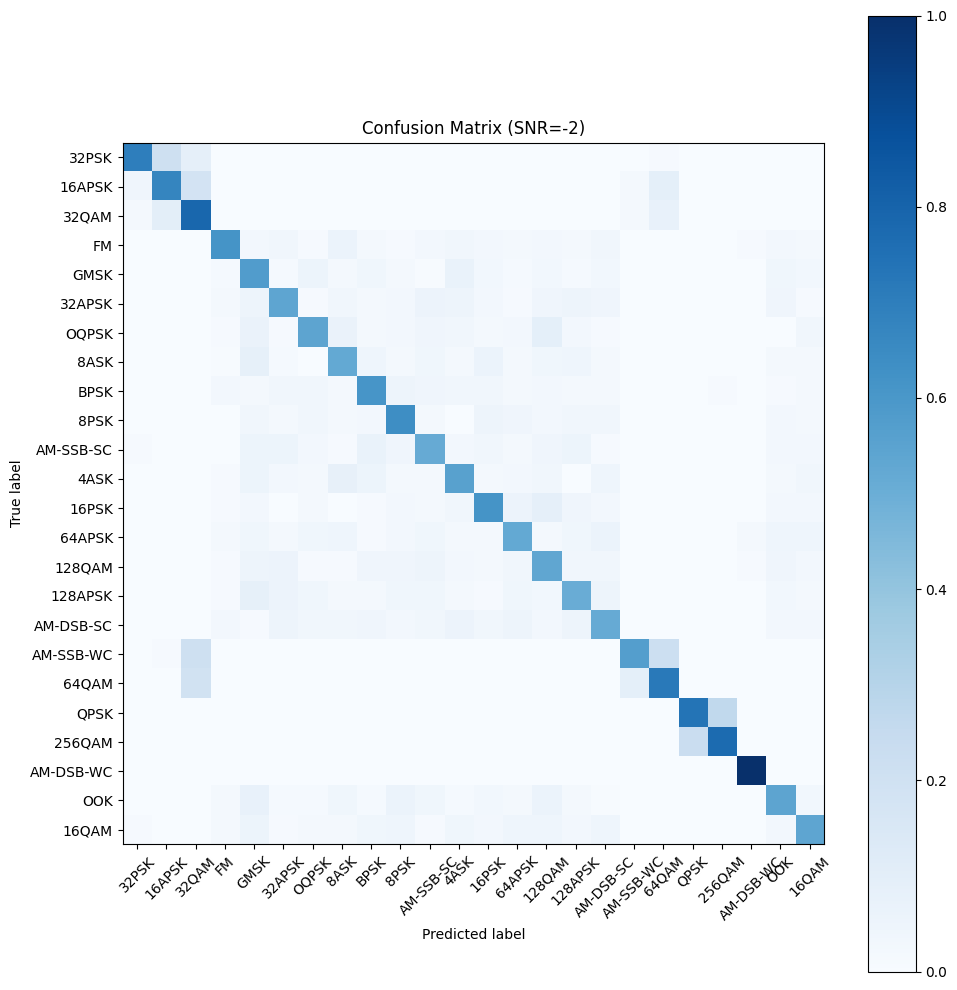

<Figure size 640x480 with 0 Axes>

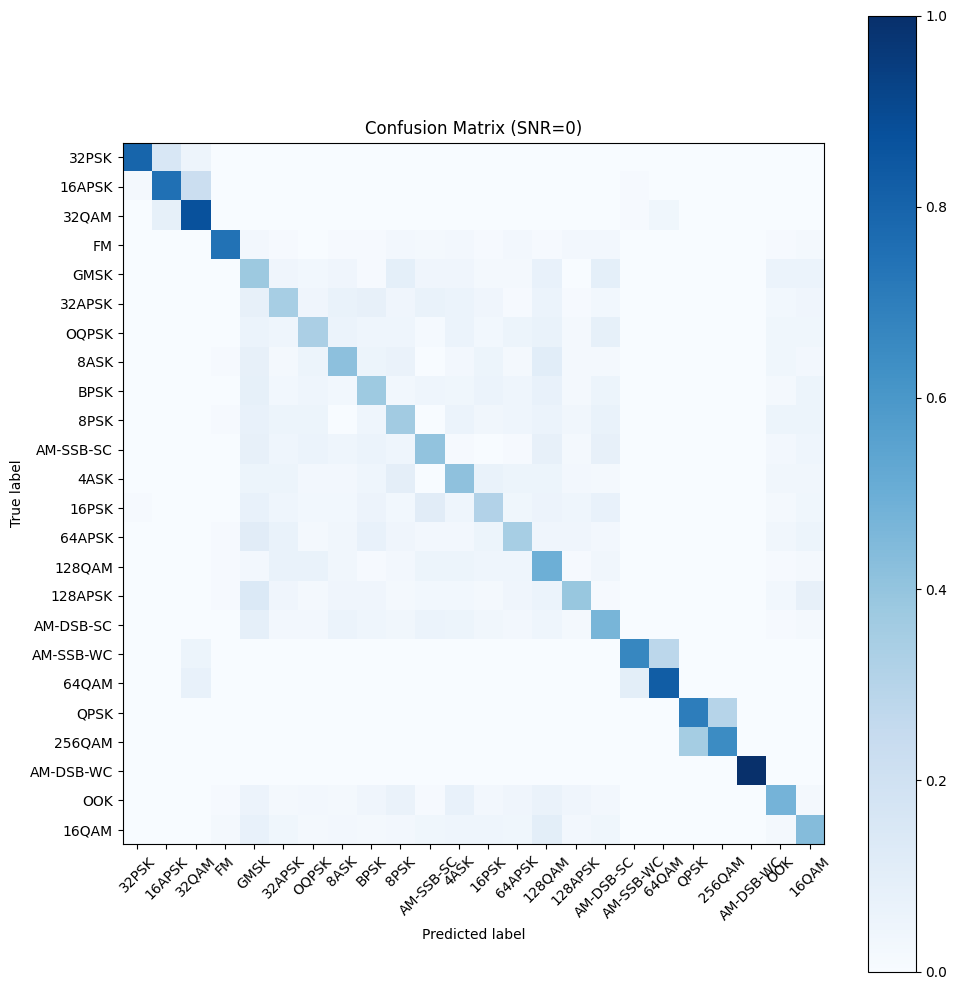

<Figure size 640x480 with 0 Axes>

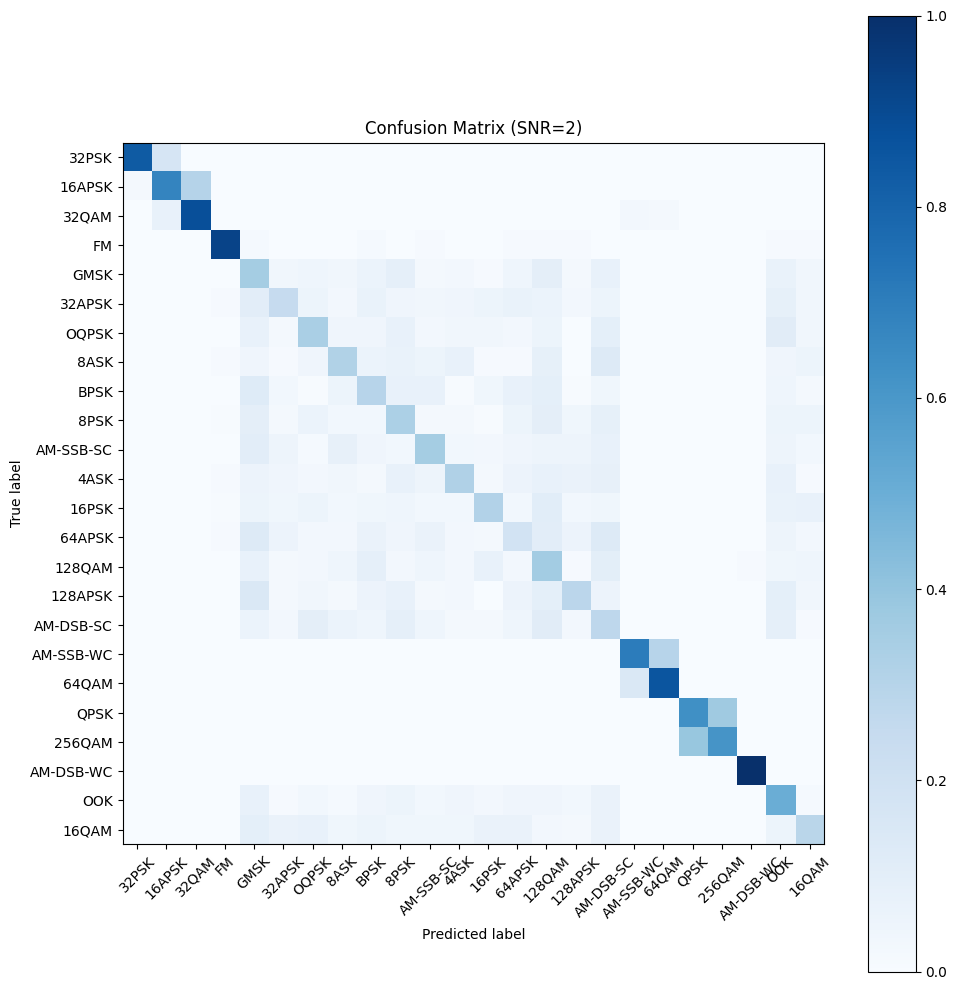

<Figure size 640x480 with 0 Axes>

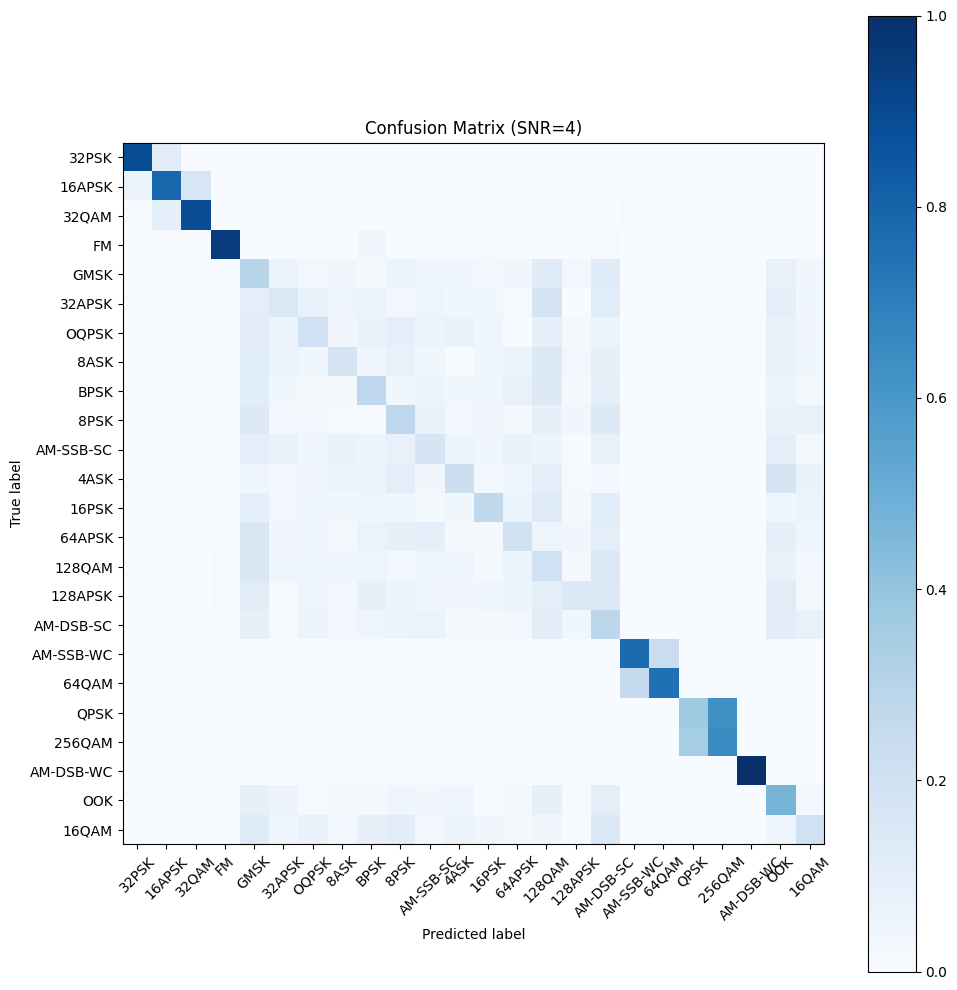

<Figure size 640x480 with 0 Axes>

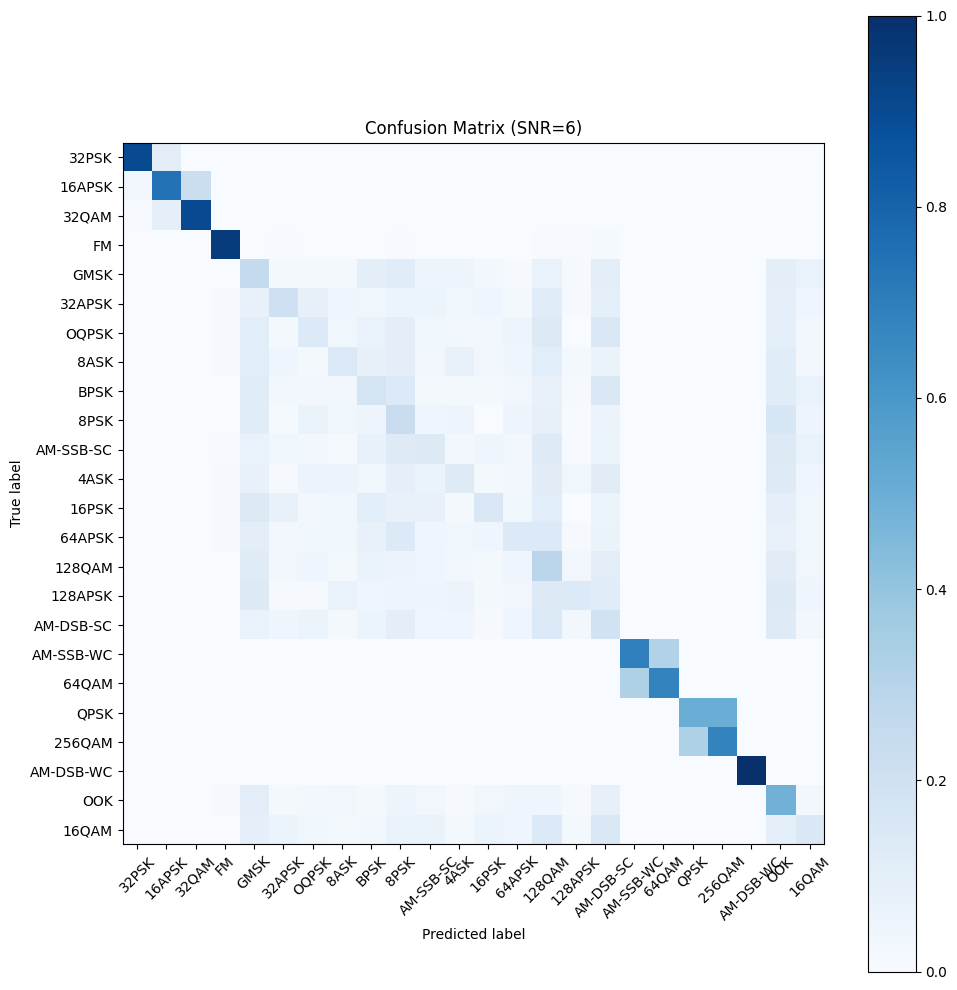

<Figure size 640x480 with 0 Axes>

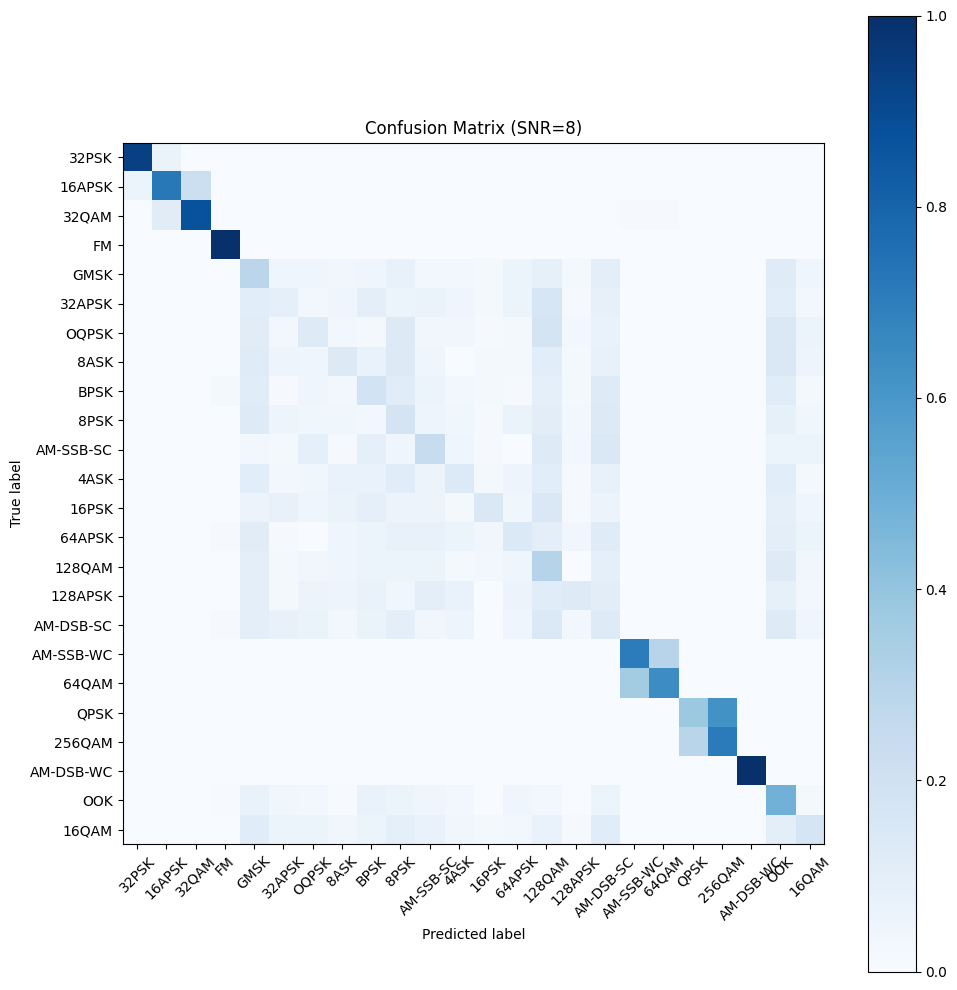

<Figure size 640x480 with 0 Axes>

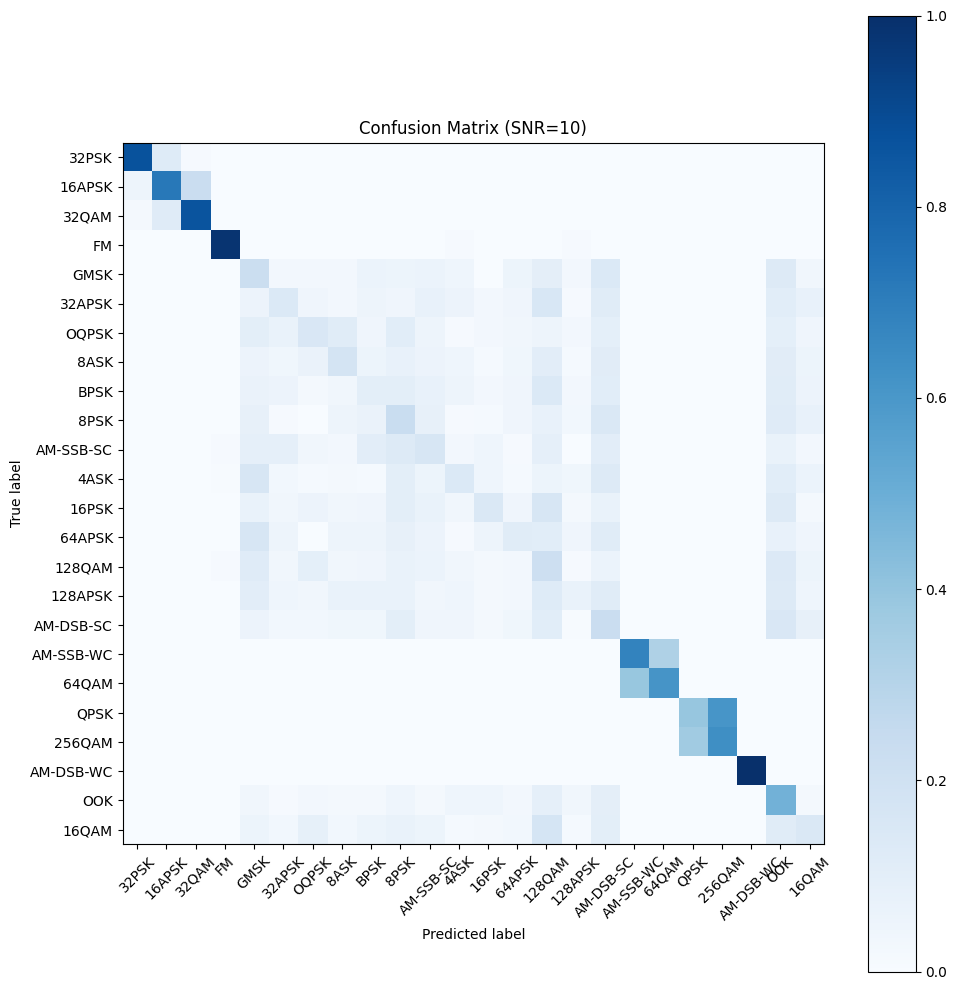

<Figure size 640x480 with 0 Axes>

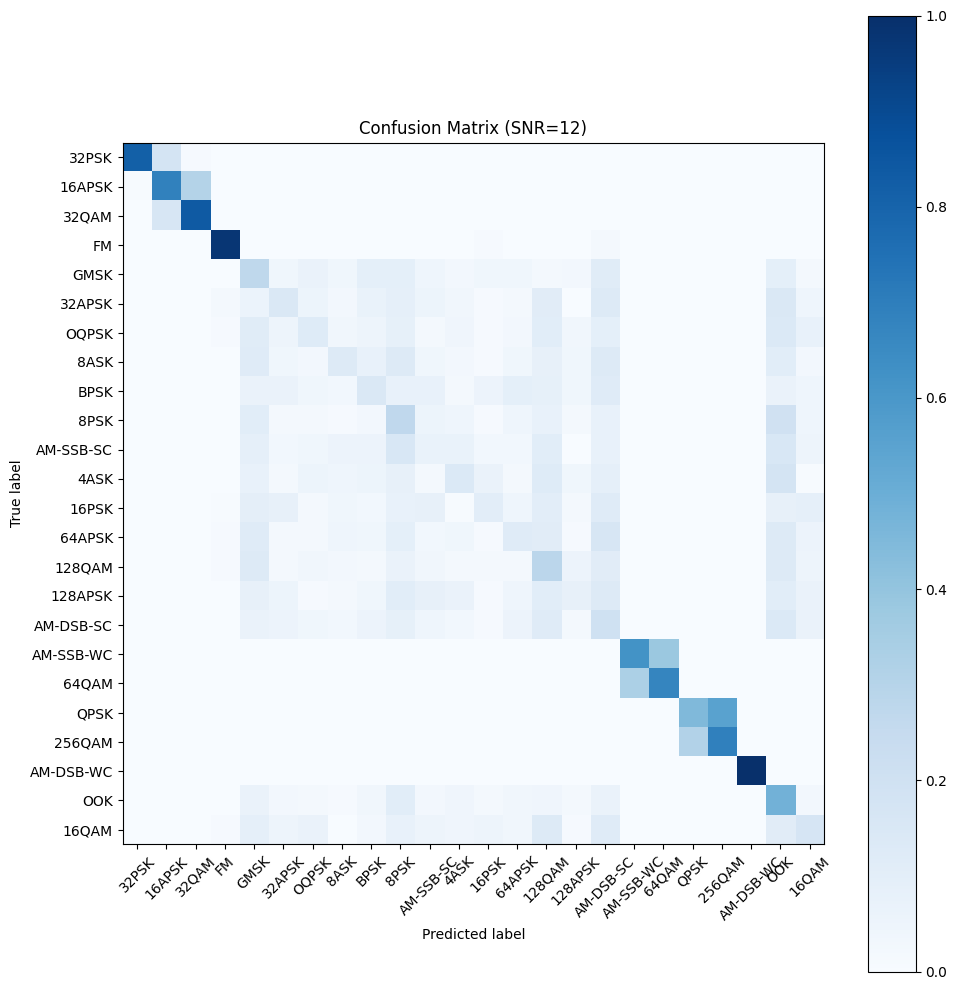

<Figure size 640x480 with 0 Axes>

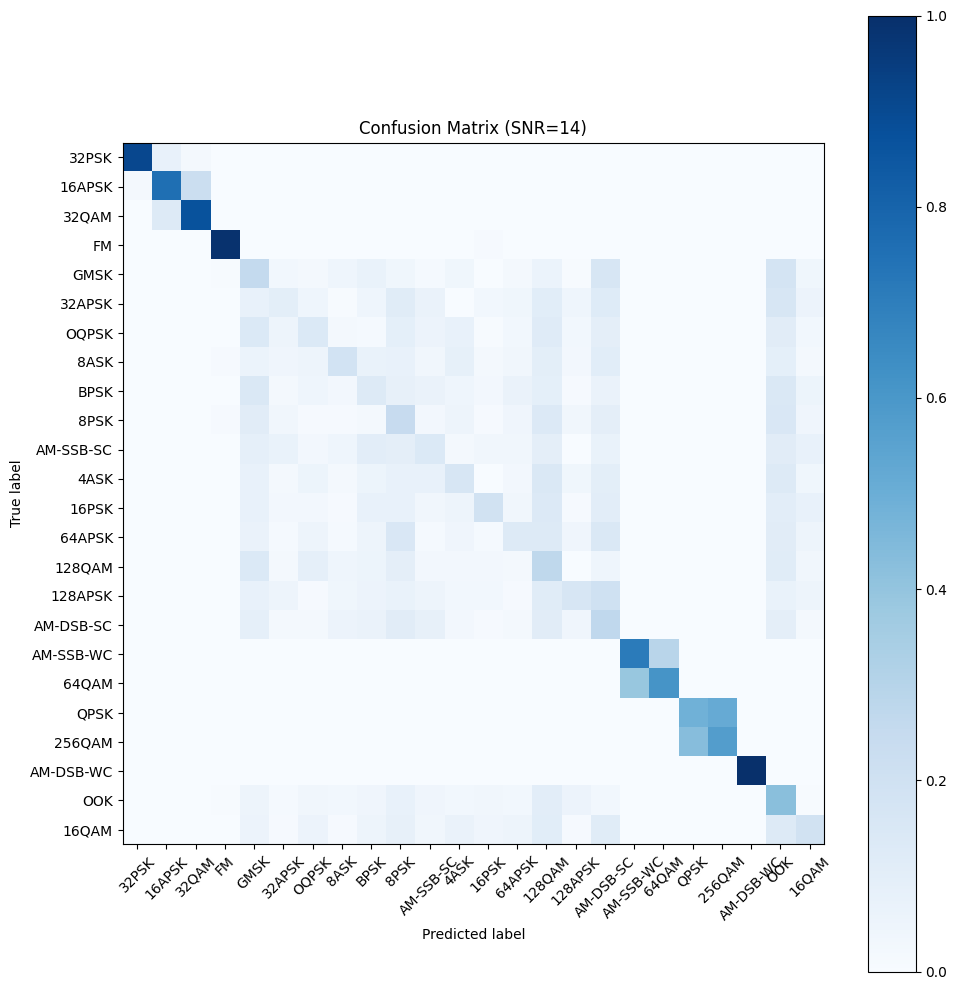

<Figure size 640x480 with 0 Axes>

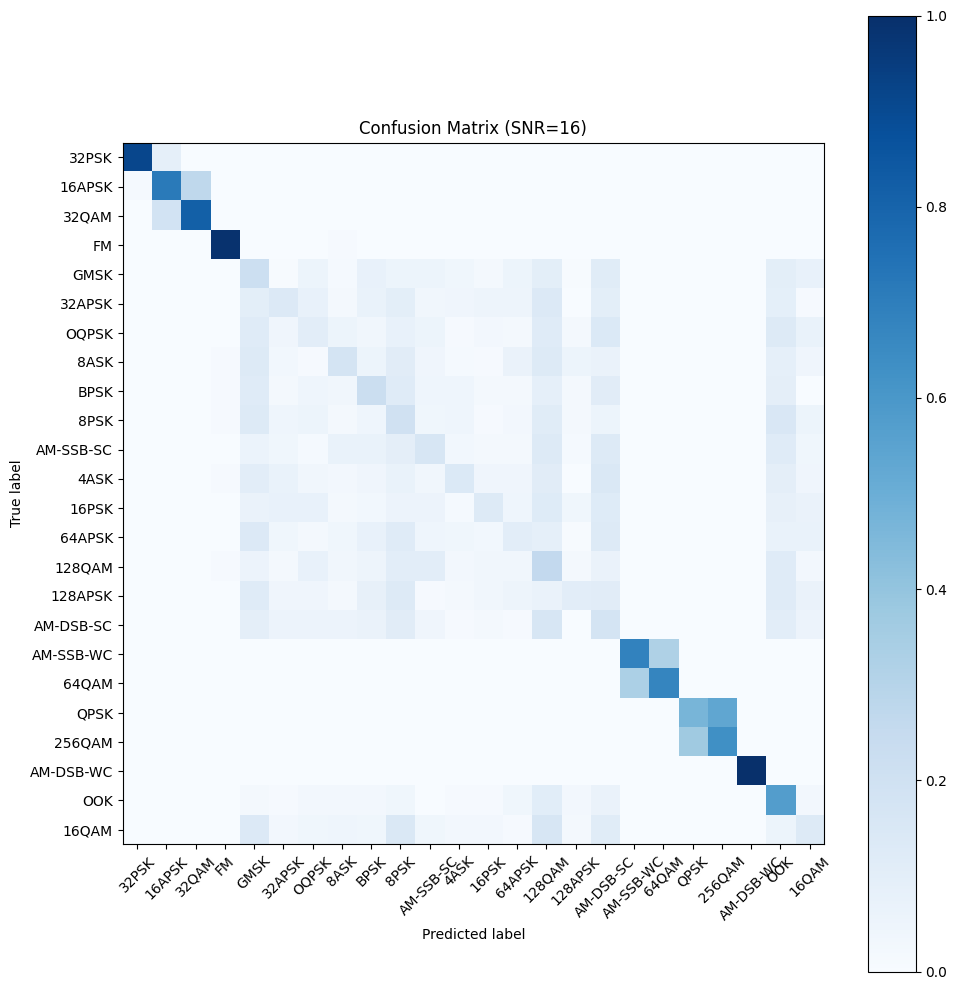

<Figure size 640x480 with 0 Axes>

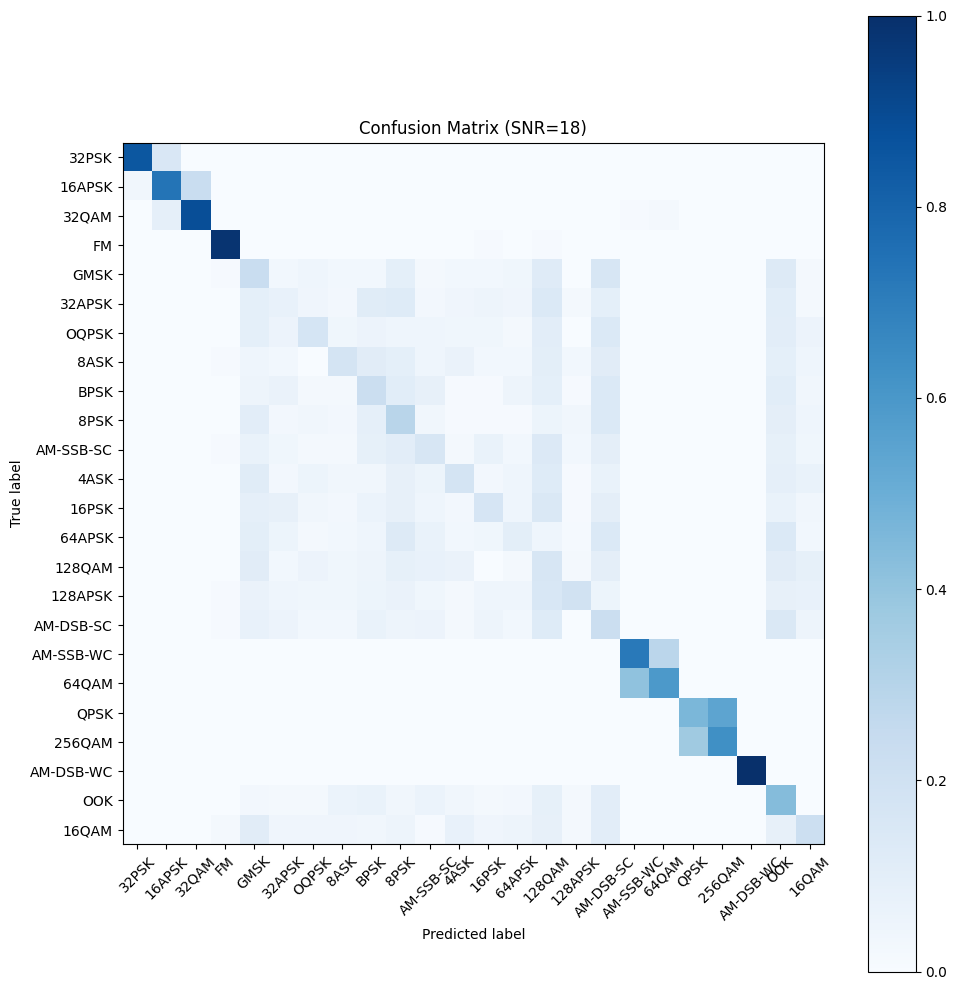

<Figure size 640x480 with 0 Axes>

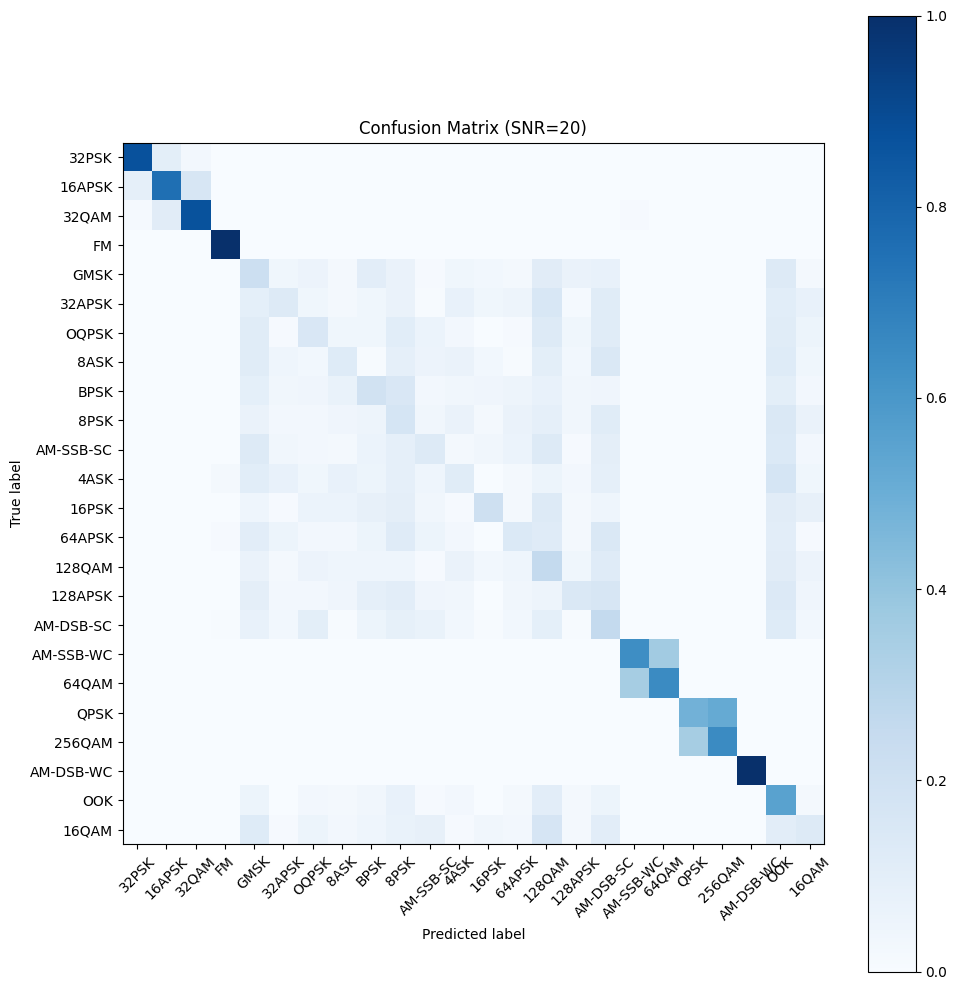

<Figure size 640x480 with 0 Axes>

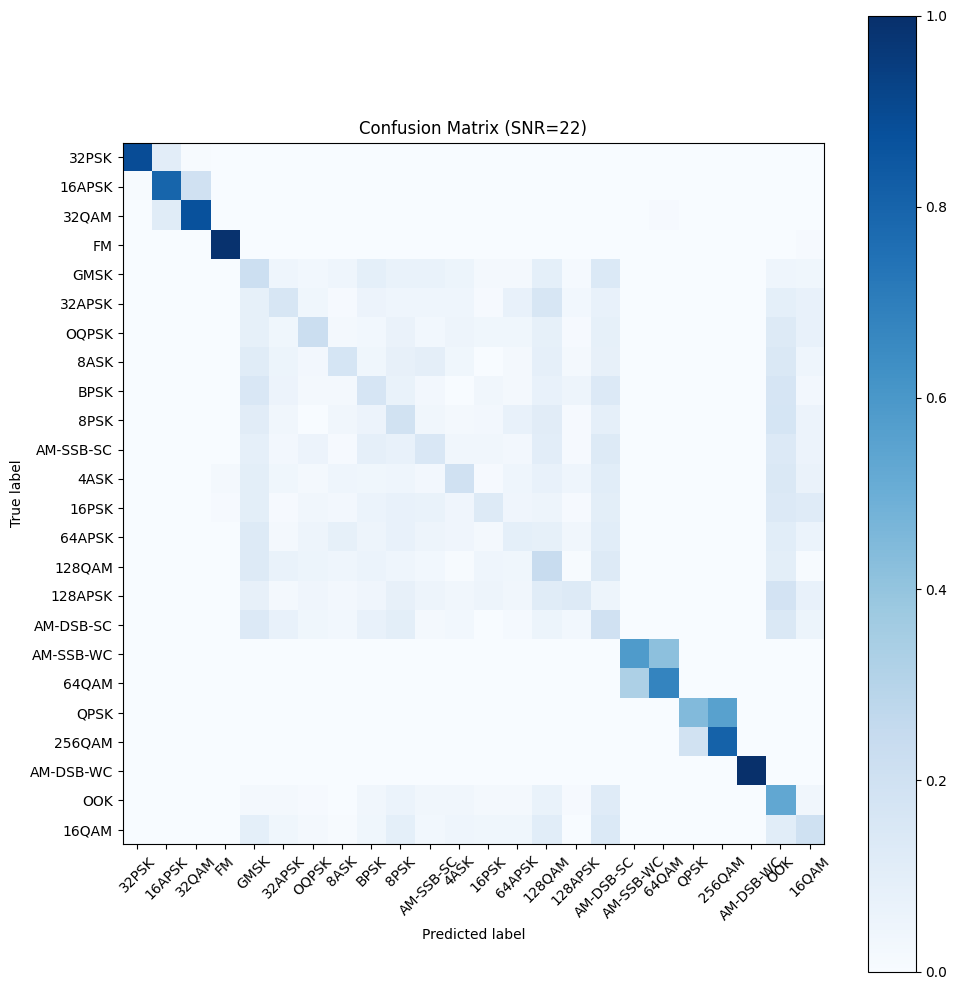

<Figure size 640x480 with 0 Axes>

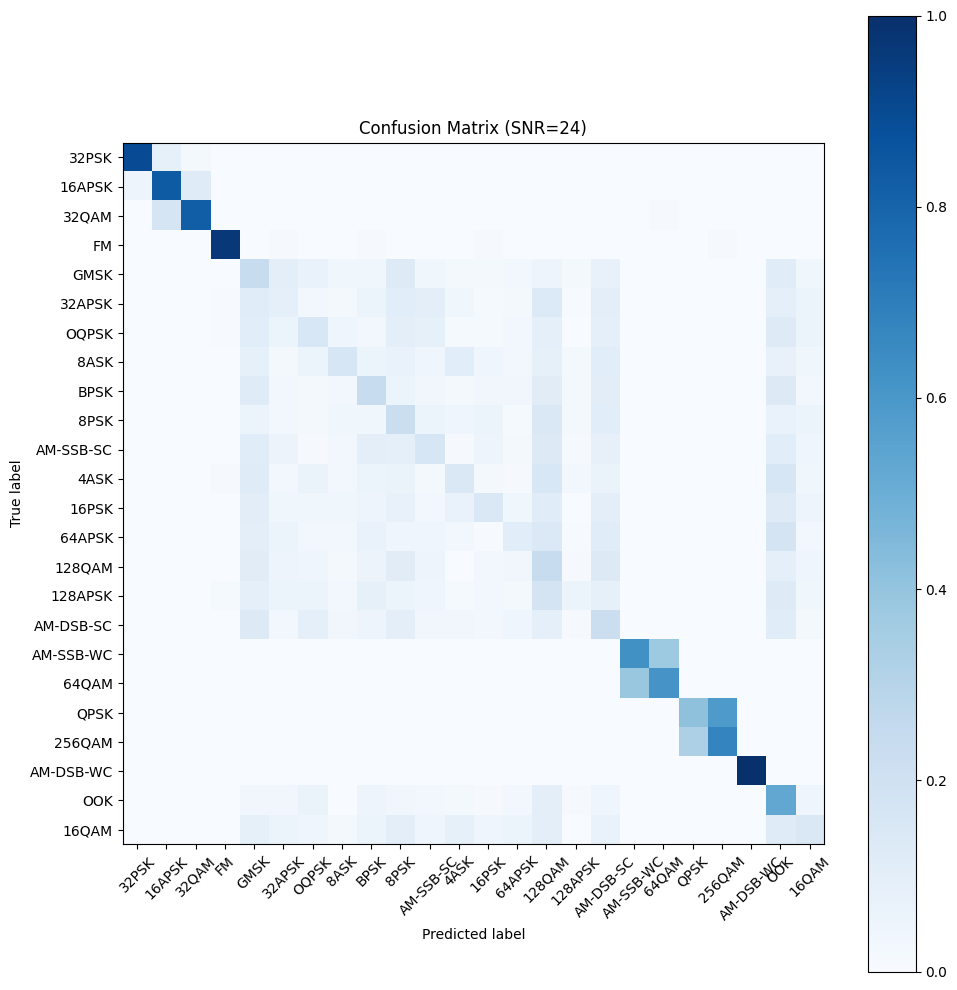

<Figure size 640x480 with 0 Axes>

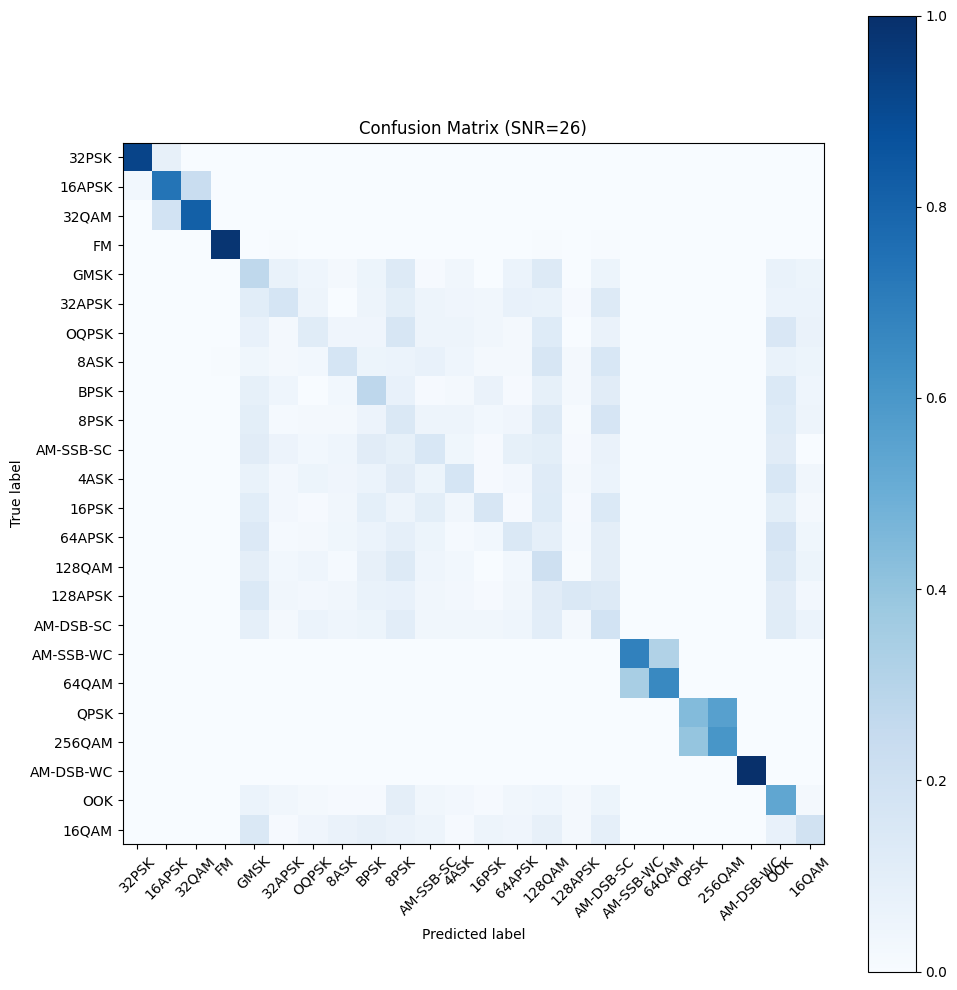

<Figure size 640x480 with 0 Axes>

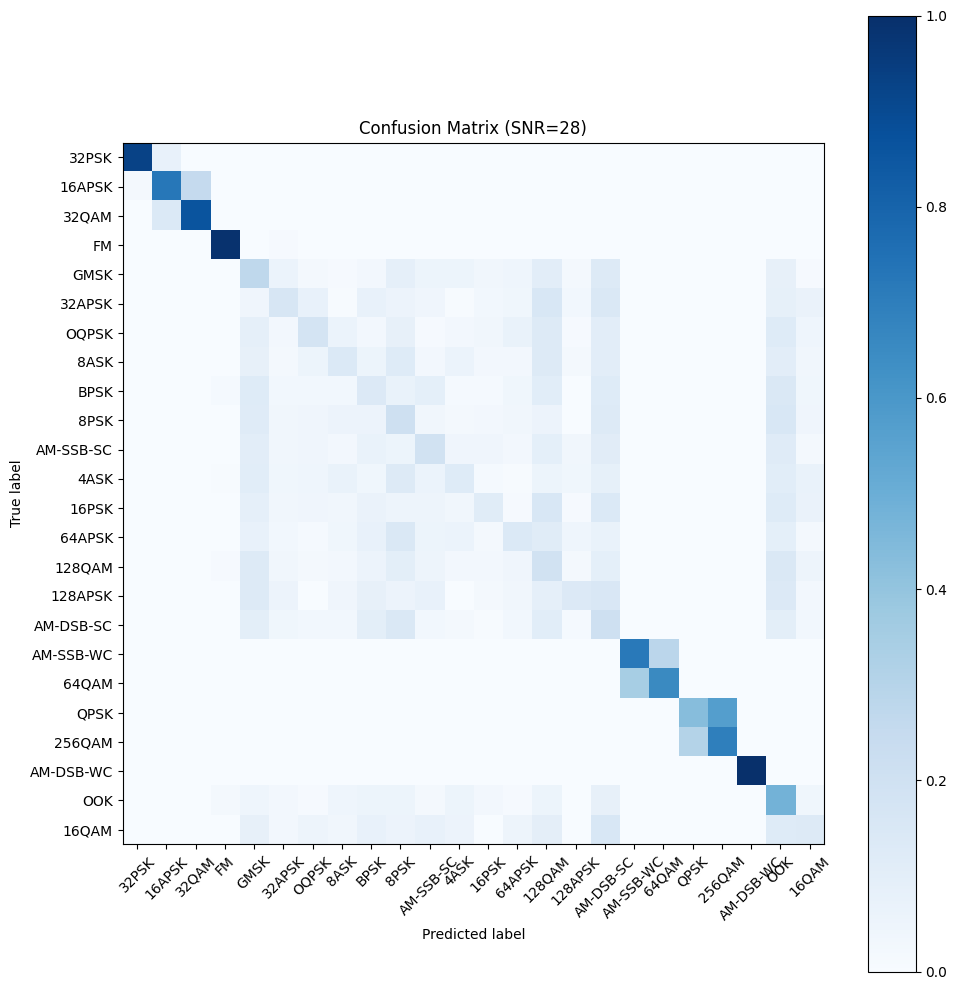

<Figure size 640x480 with 0 Axes>

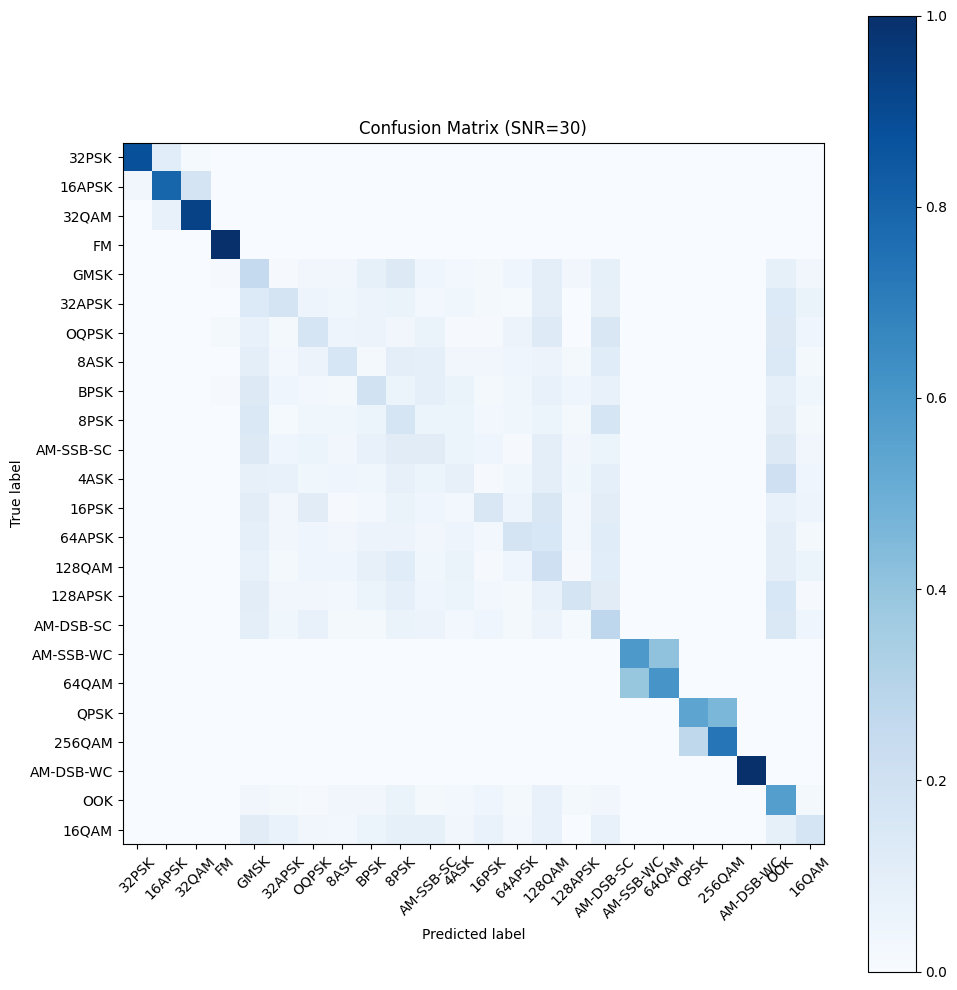

In [10]:
acc_transformer={}
acc_cnn={}
acc_resnet={}
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_transformer = model.predict(X_test_snr)
    pre_Y_cnn = cnn_model.predict(X_test_snr)
    pre_Y_resnet = resnet_model.predict(X_test_snr)
    conf_transformer = np.zeros([len(classes),len(classes)])
    confnorm_transformer = np.zeros([len(classes),len(classes)])
    conf_cnn = np.zeros([len(classes),len(classes)])
    confnorm_cnn = np.zeros([len(classes),len(classes)])
    conf_resnet = np.zeros([len(classes),len(classes)])
    confnorm_resnet = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):
        j = list(Y_test_snr[i,:]).index(1)
        k = int(np.argmax(pre_Y_transformer[i,:]))
        conf_transformer[j,k] = conf_transformer[j,k] + 1
    for i in range(0,len(classes)):
        confnorm_transformer[i,:] = conf_transformer[i,:] / np.sum(conf_transformer[i,:])
        
    for i in range(0,X_test_snr.shape[0]):
        j = list(Y_test_snr[i,:]).index(1)
        k = int(np.argmax(pre_Y_cnn[i,:]))
        conf_cnn[j,k] = conf_cnn[j,k] + 1
    for i in range(0,len(classes)):
        confnorm_cnn[i,:] = conf_cnn[i,:] / np.sum(conf_cnn[i,:])
        
    for i in range(0,X_test_snr.shape[0]):
        j = list(Y_test_snr[i,:]).index(1)
        k = int(np.argmax(pre_Y_resnet[i,:]))
        conf_resnet[j,k] = conf_resnet[j,k] + 1
    for i in range(0,len(classes)):
        confnorm_resnet[i,:] = conf_resnet[i,:] / np.sum(conf_resnet[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm_transformer, labels=classes, title="Confusion Matrix (SNR=%d)"%(snr))
    
    cor_transformer = np.sum(np.diag(conf_transformer))
    ncor_transformer = np.sum(conf_transformer) - cor_transformer
    print ("Overall Accuracy %s: "%snr, cor_transformer / (cor_transformer+ncor_transformer))
    acc_transformer[snr] = 1.0*cor_transformer/(cor_transformer+ncor_transformer)
    cor_cnn = np.sum(np.diag(conf_cnn))
    ncor_cnn = np.sum(conf_cnn) - cor_cnn
    acc_cnn[snr] = 1.0*cor_cnn/(cor_cnn+ncor_cnn)
    cor_resnet = np.sum(np.diag(conf_resnet))
    ncor_resnet = np.sum(conf_resnet) - cor_resnet
    acc_resnet[snr] = 1.0*cor_resnet/(cor_resnet+ncor_resnet)

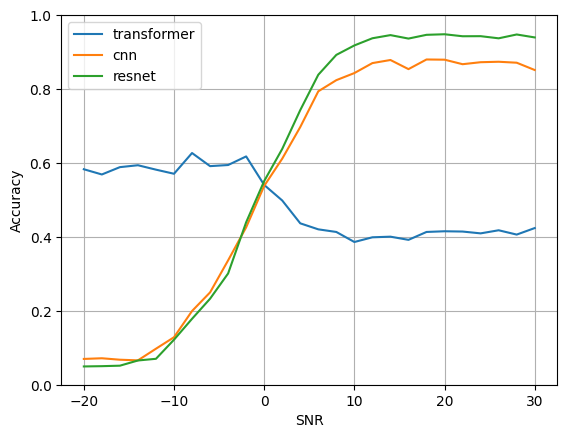

In [11]:
plt.plot(acc_transformer.keys(),acc_transformer.values(), label='transformer')
plt.plot(acc_cnn.keys(),acc_cnn.values(), label='cnn')
plt.plot(acc_resnet.keys(), acc_resnet.values(), label='resnet')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.ylim(0, 1)
plt.grid(True)
plt.show()